# Method to find the parameters of the HOTS algorithm
## Parameters of the time surfaces
We want to build time surfaces that will be as informative as possible. For this, we can play with 2 parameters: 
- its spatial size defined by $R$
- its time constant $\tau$

Empirically, we did not observed a large impact of $R$, let's set it to 4 for the first layer such that time surfaces will be 9x9x2 matrices

Then, we can define $\tau$ as a function of the Inter-Spike-Interval (ISI) that is defined on different datasets: 
- Poker DVS: mean ISI -> $6.87 \mu s$
- N-MNIST: mean ISI -> $82.4 \mu s$
- DVS Gesture: mean ISI -> $26.3 \mu s$

Empirically, optimal $\tau$s that were found are: 
- Poker DVS: $\tau = .5 m s \cdot 2$
- N-MNIST: $\tau = 10 m s \cdot 2$
- DVS Gesture: $\tau = 3 m s \cdot 2$

In [1]:
print(.5/6.87*1e3, 10/82.4*1e3, 3/26.3*1e3)

72.78020378457059 121.35922330097087 114.06844106463879


Seems like you want: $\frac{\tau}{\mu_{ISI}} \approx 100$

We want to confirm this by studying the entropy of time surfaces when we vary $\tau$

In [28]:
def timesurfaces_entropy(all_ts):
    def entropy(timesurface):
        hist = torch.histc(timesurface, bins = 256, min = 0, max = 1)
        return -torch.nansum(hist*torch.log2(hist))
    
    ent_by_ev = torch.zeros([all_ts.shape[0]])
    for event_indice in range(all_ts.shape[0]):
        ent = entropy(all_ts[event_indice,:,:,:])
        ent_by_ev[event_indice] = ent
    return ent_by_ev

In [41]:
import tonic
from hots.timesurface import timesurface
from hots.utils import get_loader, get_dataset_info
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

number of samples in the trainset: 48
number of samples in the testset: 48
----------------------------------------
number of samples in each class for the trainset: [12. 12. 12. 12.]
number of samples in each class for the testset: [12. 12. 12. 12.]
----------------------------------------
Mean value for time: 17283.270833333332
Mean value for mean_isi: 6.934187320013135
Mean value for nb_events: 2991.0208333333335


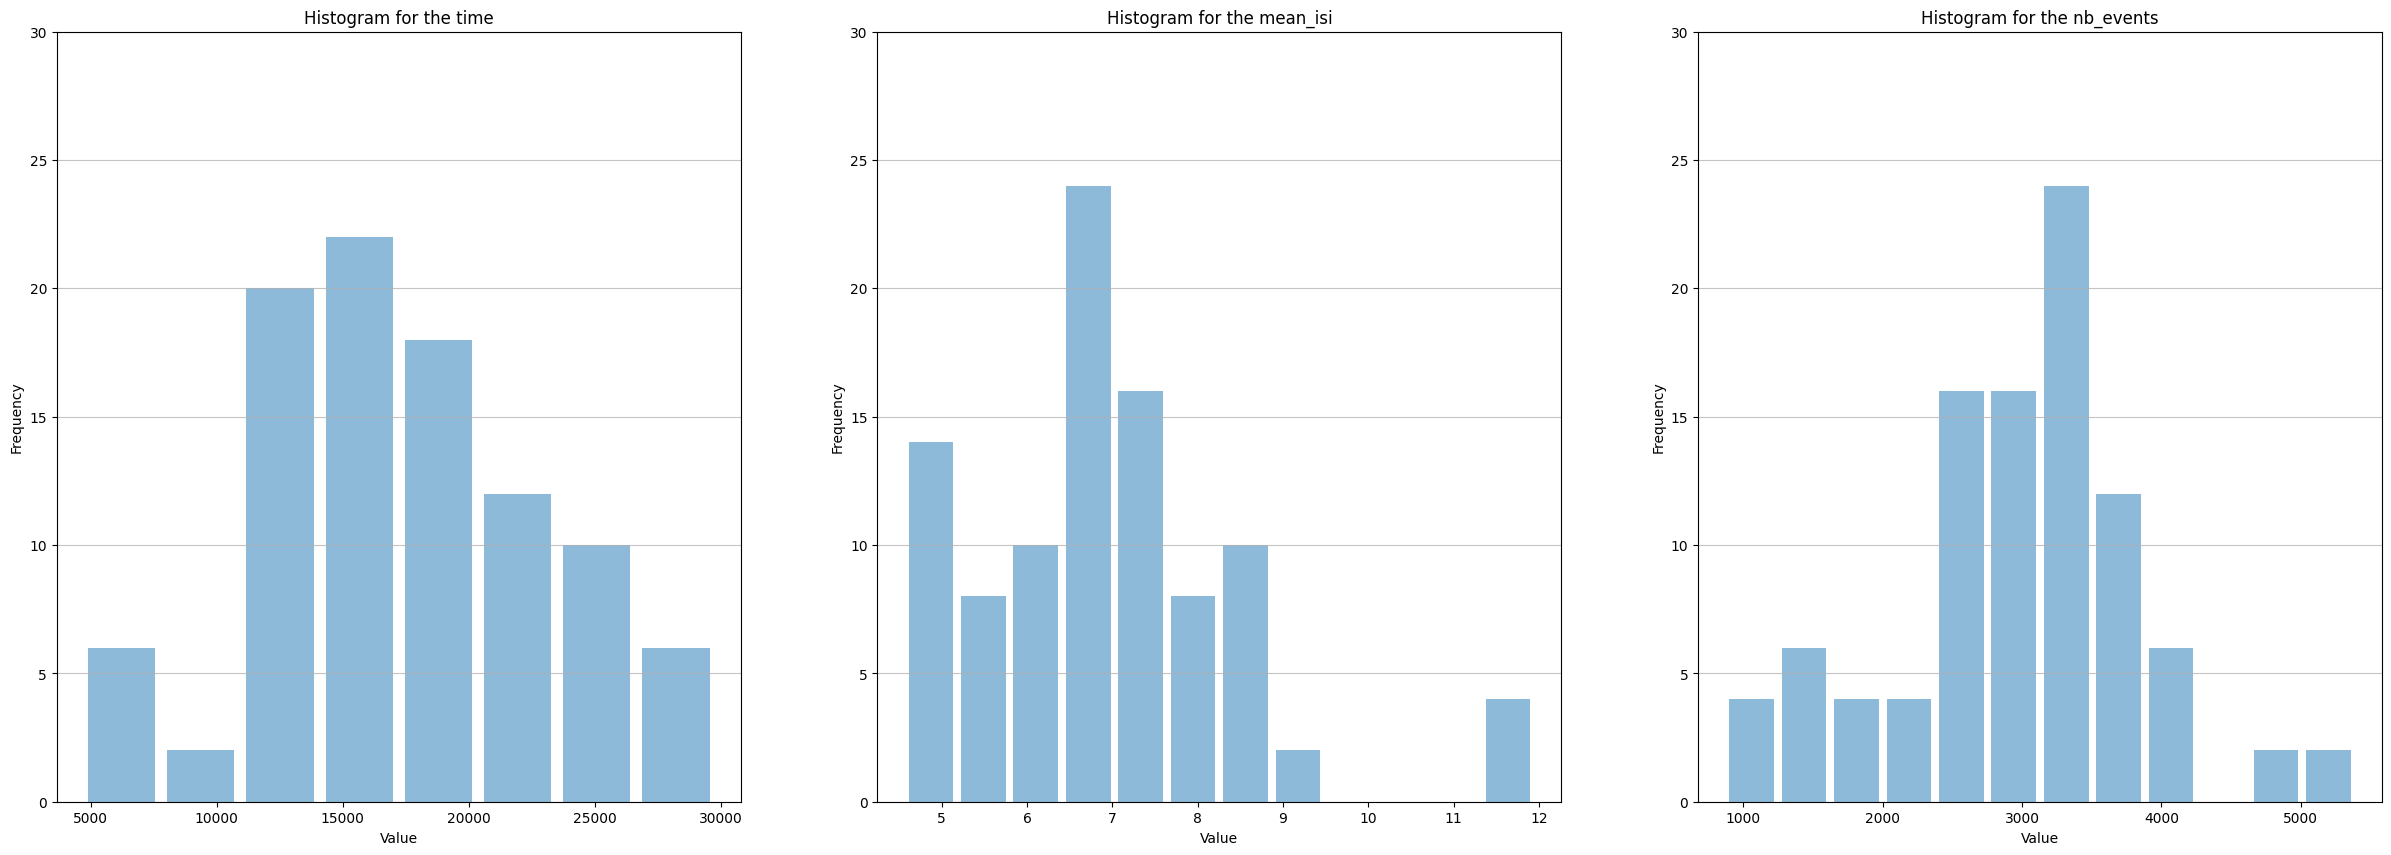

In [3]:
transform = tonic.transforms.NumpyAsType(int)
dataset = tonic.datasets.POKERDVS(save_to='../../Data/', train=True,transform=transform)
loader = get_loader(dataset)
get_dataset_info(dataset,dataset, properties = ['time', 'mean_isi', 'nb_events']);

In [47]:
tauz = [1, 5, 10, 100, 1000, 10000, 1e5, 1e6]
entropy_by_tau_None = torch.zeros([len(tauz)])
for indice, tau in tqdm(enumerate(tauz)):
    entropy_for_loader = 0
    for events, target in loader:
        ts, ind_filtered = timesurface(events.squeeze(), dataset.sensor_size, dataset.ordering, tau = tau)
        ent_by_ev = timesurfaces_entropy(ts)
        entropy_for_loader += torch.mean(ent_by_ev)
    entropy_by_tau_None[indice] = entropy_for_loader/len(loader)
plt.semilogx(tauz,entropy_by_tau_None, 'o');

0it [00:00, ?it/s]

In [52]:
R = 2

surface_dimensions=[2*R+1,2*R+1]

entropy_by_tau_2 = torch.zeros([len(tauz)])
for indice, tau in tqdm(enumerate(tauz)):
    entropy_for_loader = 0
    for events, target in loader:
        ts, ind_filtered = timesurface(events.squeeze(), dataset.sensor_size, dataset.ordering, tau = tau, surface_dimensions = surface_dimensions)
        ent_by_ev = timesurfaces_entropy(ts)
        entropy_for_loader += torch.mean(ent_by_ev)
    entropy_by_tau_2[indice] = entropy_for_loader/len(loader)
plt.semilogx(tauz,entropy_by_tau_2, 'o');

0it [00:00, ?it/s]

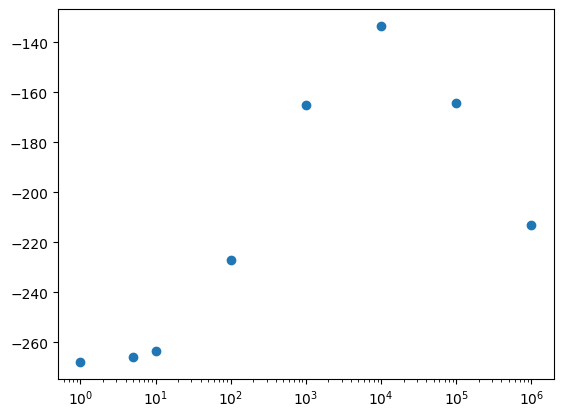

In [53]:
plt.semilogx(tauz,entropy_by_tau, 'o');

0it [00:00, ?it/s]

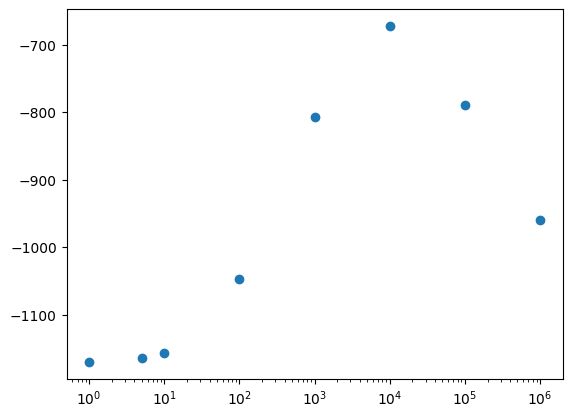

In [54]:
R = 4

surface_dimensions=[2*R+1,2*R+1]

entropy_by_tau_4 = torch.zeros([len(tauz)])
for indice, tau in tqdm(enumerate(tauz)):
    entropy_for_loader = 0
    for events, target in loader:
        ts, ind_filtered = timesurface(events.squeeze(), dataset.sensor_size, dataset.ordering, tau = tau, surface_dimensions = surface_dimensions)
        ent_by_ev = timesurfaces_entropy(ts)
        entropy_for_loader += torch.mean(ent_by_ev)
    entropy_by_tau_4[indice] = entropy_for_loader/len(loader)
plt.semilogx(tauz,entropy_by_tau_4, 'o');

For the shannon entropy it seems that there is an optimal $\tau$ to define timesurfaces independant of the timesurface radius.